In [ ]:
import pandas as pd
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv('dataset.csv')

In [ ]:
# Remove quotes from both columns
df['user_prompt'] = df['user_prompt'].str.strip('"')
df['label'] = df['label'].str.strip('"')

print("After cleaning:")
print("Unique labels:", df['label'].unique())
print("\nLabel distribution:")
print(df['label'].value_counts())

After cleaning:
Unique labels: ['buy_medicine' 'add_to_cart']

Label distribution:
label
buy_medicine    190
add_to_cart     190
Name: count, dtype: int64


In [ ]:
print(df['label'].value_counts())

label
buy_medicine    190
add_to_cart     190
Name: count, dtype: int64


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['user_prompt'] = df['user_prompt'].apply(clean_text)
df['label_enc'] = df['label'].apply(lambda x: 0 if x=='buy_medicine' else 1)

# Check class balance
print(df['label'].value_counts())

label
buy_medicine    190
add_to_cart     190
Name: count, dtype: int64


In [ ]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['user_prompt']).toarray()
y = df['label_enc'].values.astype(float)

In [ ]:
class MedicineDatasetBinary(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = MedicineDatasetBinary(X_tfidf, y)

In [ ]:
class NetBinary(nn.Module):
    def __init__(self, input_dim):
        super(NetBinary, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)


Fold 1
Epoch 1/30, Loss: 0.6594
Epoch 2/30, Loss: 0.5441
Epoch 3/30, Loss: 0.3399
Epoch 4/30, Loss: 0.1383
Epoch 5/30, Loss: 0.0446
Epoch 6/30, Loss: 0.0174
Epoch 7/30, Loss: 0.0093
Epoch 8/30, Loss: 0.0059
Epoch 9/30, Loss: 0.0042
Epoch 10/30, Loss: 0.0031
Epoch 11/30, Loss: 0.0024
Epoch 12/30, Loss: 0.0019
Epoch 13/30, Loss: 0.0016
Epoch 14/30, Loss: 0.0013
Epoch 15/30, Loss: 0.0011
Epoch 16/30, Loss: 0.0010
Epoch 17/30, Loss: 0.0008
Epoch 18/30, Loss: 0.0007
Epoch 19/30, Loss: 0.0007
Epoch 20/30, Loss: 0.0006
Epoch 21/30, Loss: 0.0005
Epoch 22/30, Loss: 0.0005
Epoch 23/30, Loss: 0.0004
Epoch 24/30, Loss: 0.0004
Epoch 25/30, Loss: 0.0004
Epoch 26/30, Loss: 0.0003
Epoch 27/30, Loss: 0.0003
Epoch 28/30, Loss: 0.0003
Epoch 29/30, Loss: 0.0002
Epoch 30/30, Loss: 0.0002
Accuracy Fold 1: 100.00%

Fold 2
Epoch 1/30, Loss: 0.6546
Epoch 2/30, Loss: 0.5374
Epoch 3/30, Loss: 0.3345
Epoch 4/30, Loss: 0.1343
Epoch 5/30, Loss: 0.0420
Epoch 6/30, Loss: 0.0162
Epoch 7/30, Loss: 0.0086
Epoch 8/30, L

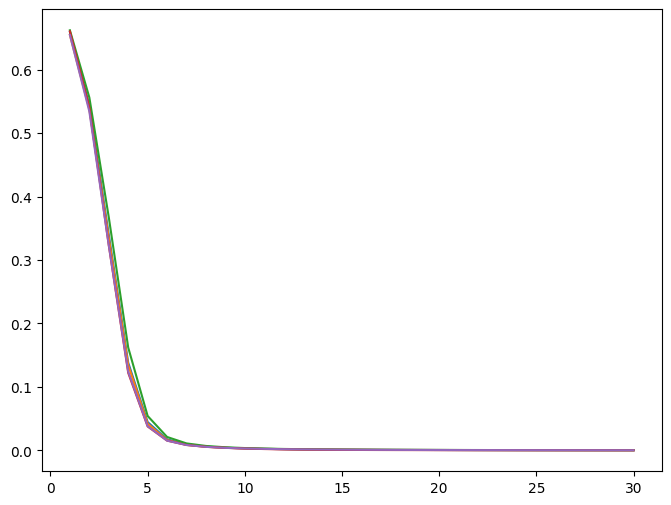

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
epochs = 30
batch_size = 16

all_accuracies = []
all_y_true = []
all_y_pred = []

plt.figure(figsize=(8,6))

for fold, (train_idx, test_idx) in enumerate(kf.split(X_tfidf, y)):
    print(f"\nFold {fold+1}")

    train_subset = Subset(dataset, train_idx)
    test_subset = Subset(dataset, test_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    model = NetBinary(X_tfidf.shape[1])
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    epoch_losses = []

    # Training
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    plt.plot(range(1, epochs+1), epoch_losses, label=f'Fold {fold+1}')

    # Evaluation
    model.eval()
    y_true_fold = []
    y_pred_fold = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            preds = torch.sigmoid(outputs)
            predicted = (preds > 0.5).float()

            y_true_fold.extend(y_batch.detach().cpu().numpy().flatten().tolist())
            y_pred_fold.extend(predicted.detach().cpu().numpy().flatten().tolist())

    acc = np.mean(np.array(y_true_fold) == np.array(y_pred_fold))
    print(f"Accuracy Fold {fold+1}: {acc*100:.2f}%")

    all_accuracies.append(acc)
    all_y_true.extend(y_true_fold)
    all_y_pred.extend(y_pred_fold)



OVERALL RESULTS
Average Accuracy: 100.00% (±0.00%)
Min Accuracy: 100.00%
Max Accuracy: 100.00%

CLASSIFICATION REPORT
              precision    recall  f1-score   support

buy_medicine       1.00      1.00      1.00       190
 add_to_cart       1.00      1.00      1.00       190

    accuracy                           1.00       380
   macro avg       1.00      1.00      1.00       380
weighted avg       1.00      1.00      1.00       380

CONFUSION MATRIX
                    Predicted
                buy_med  add_cart
Actual buy_med   [ 190         0]
       add_cart  [   0       190]



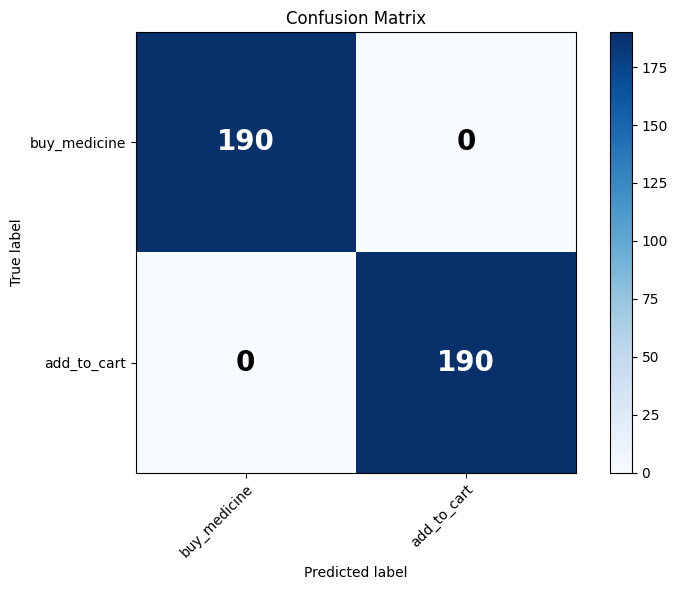

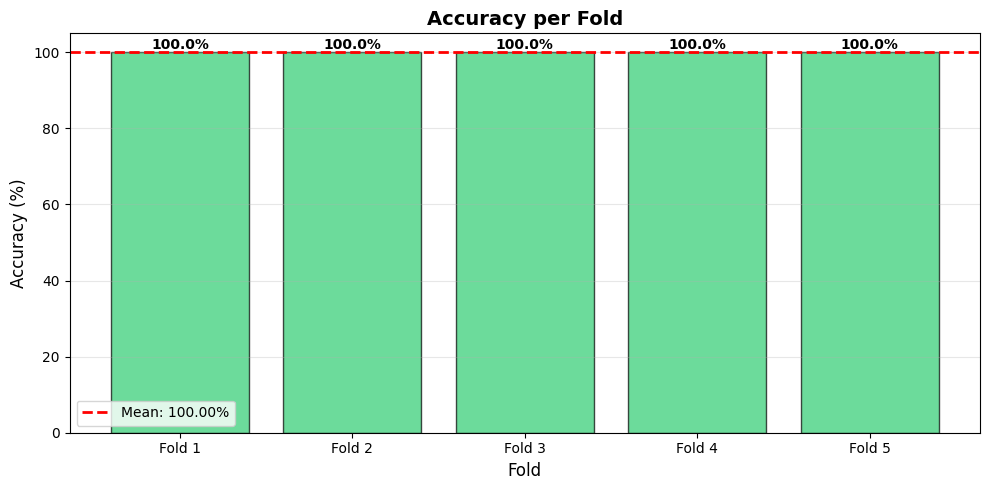

In [ ]:
# Calculate and display average accuracy
print(f"\n{'='*60}")
print(f"OVERALL RESULTS")
print(f"{'='*60}")
print(f"Average Accuracy: {np.mean(all_accuracies)*100:.2f}% (±{np.std(all_accuracies)*100:.2f}%)")
print(f"Min Accuracy: {np.min(all_accuracies)*100:.2f}%")
print(f"Max Accuracy: {np.max(all_accuracies)*100:.2f}%")

# Classification Report
print(f"\n{'='*60}")
print("CLASSIFICATION REPORT")
print(f"{'='*60}")
print(classification_report(all_y_true, all_y_pred, labels=[0, 1],
                            target_names=['buy_medicine', 'add_to_cart'],
                            zero_division=0))

# Confusion Matrix
cm = confusion_matrix(all_y_true, all_y_pred, labels=[0, 1])
print(f"{'='*60}")
print("CONFUSION MATRIX")
print(f"{'='*60}")
print("                    Predicted")
print("                buy_med  add_cart")
print(f"Actual buy_med   [{cm[0,0]:4d}      {cm[0,1]:4d}]")
print(f"       add_cart  [{cm[1,0]:4d}      {cm[1,1]:4d}]")
print(f"{'='*60}\n")

# Visualize Confusion Matrix
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Confusion Matrix Heatmap
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
fig.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['buy_medicine', 'add_to_cart'],
       yticklabels=['buy_medicine', 'add_to_cart'],
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels for better readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add text annotations to confusion matrix
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()

# Accuracy per fold visualization
plt.figure(figsize=(10, 5))
folds = [f'Fold {i+1}' for i in range(len(all_accuracies))]
colors = ['#2ecc71' if acc >= 0.9 else '#f39c12' if acc >= 0.8 else '#e74c3c'
          for acc in all_accuracies]

bars = plt.bar(folds, [acc*100 for acc in all_accuracies], color=colors, alpha=0.7, edgecolor='black')
plt.axhline(y=np.mean(all_accuracies)*100, color='red', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(all_accuracies)*100:.2f}%')

# Add value labels on bars
for bar, acc in zip(bars, all_accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc*100:.1f}%',
             ha='center', va='bottom', fontweight='bold')

plt.title('Accuracy per Fold', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12)
plt.xlabel('Fold', fontsize=12)
plt.ylim([0, 105])
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# Prediction function
def predict(prompt):
    prompt_clean = clean_text(prompt)
    vec = vectorizer.transform([prompt_clean]).toarray()
    tensor = torch.tensor(vec, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        output = model(tensor)
        prob = torch.sigmoid(output).item()

    label = 'buy_medicine' if prob < 0.5 else 'add_to_cart'
    confidence = (1 - prob) if label == 'buy_medicine' else prob

    return label, confidence

# Example predictions
print(f"\n{'='*60}")
print("EXAMPLE PREDICTIONS")
print(f"{'='*60}")

test_prompts = [
    "buy 1 Panadol Extra",
    "add 2 Aspirin to cart",
    "purchase 3 Ibuprofen",
    "put vitamin C in my cart",
    "I want to buy Telfast",
    "add Cough syrup to my cart",
    "get me some Paracetamol",
    "add 5 Amoxicillin to cart",
    "I want to buy one Asprini"
]

for prompt in test_prompts:
    label, confidence = predict(prompt)
    print(f"'{prompt}'")
    print(f"   → {label} (confidence: {confidence:.1%})\n")


EXAMPLE PREDICTIONS
'buy 1 Panadol Extra'
   → buy_medicine (confidence: 100.0%)

'add 2 Aspirin to cart'
   → add_to_cart (confidence: 100.0%)

'purchase 3 Ibuprofen'
   → buy_medicine (confidence: 78.3%)

'put vitamin C in my cart'
   → add_to_cart (confidence: 99.9%)

'I want to buy Telfast'
   → buy_medicine (confidence: 97.9%)

'add Cough syrup to my cart'
   → add_to_cart (confidence: 100.0%)

'get me some Paracetamol'
   → buy_medicine (confidence: 78.3%)

'add 5 Amoxicillin to cart'
   → add_to_cart (confidence: 100.0%)

'I want to buy one Asprini'
   → buy_medicine (confidence: 92.3%)



In [ ]:
!pip install fuzzywuzzy

In [ ]:
import re
from fuzzywuzzy import process

# Fixed medicine list
medicines = [
    "Panadol Extra", "Aspirin", "Telfast", "Metformin",
    "Insulin Pen", "Tamoxifen", "Imatinib", "Orlistat",
    "Prozac", "Zoloft"
]

# Map number words to digits (only exact matches, no fuzzy)
number_words = {
    "one":1, "two":2, "three":3, "four":4, "five":5,
    "six":6, "seven":7, "eight":8, "nine":9, "ten":10
}

def parse_quantity(word):
    """Return quantity only if exact digit or exact number word"""
    word = word.lower()
    if word.isdigit():
        return int(word)
    if word in number_words:
        return number_words[word]
    return None  # do not correct unknown words

def extract_medicine_and_quantity(prompt):
    words = prompt.split()
    quantity = None

    # 1️ Look for quantity (digits or exact number words)
    for w in words:
        q = parse_quantity(w)
        if q is not None:
            quantity = q
            break

    # Default quantity = 1
    if quantity is None:
        quantity = 1

    # 2️ Remove digits and exact number words before medicine matching
    prompt_no_numbers = ' '.join([w for w in words if parse_quantity(w) is None])

    # 3️ Fuzzy match medicine names only
    best_match, score = process.extractOne(prompt_no_numbers, medicines)
    medicine = best_match if score >= 70 else None

    return medicine, quantity


In [ ]:
prompts = [
    "I want two Panadoll Extra",
    "Add 1 Aspirin to cart",
    "buy 3 Metformn",
    "give me two Telfast",
    "one Insulin Pen please"
]

for p in prompts:
    med, qty = extract_medicine_and_quantity(p)
    label, confidence = predict(p)
    print(f"'{p}'")
    print(f"→ {label} (confidence: {confidence:.1%})")
    print(f"Medicine: {med}, Quantity: {qty}\n")


'I want two Panadoll Extra'
→ buy_medicine (confidence: 85.1%)
Medicine: Panadol Extra, Quantity: 2

'Add 1 Aspirin to cart'
→ add_to_cart (confidence: 100.0%)
Medicine: Aspirin, Quantity: 1

'buy 3 Metformn'
→ buy_medicine (confidence: 100.0%)
Medicine: Metformin, Quantity: 3

'give me two Telfast'
→ buy_medicine (confidence: 95.4%)
Medicine: Telfast, Quantity: 2

'one Insulin Pen please'
→ buy_medicine (confidence: 94.8%)
Medicine: Insulin Pen, Quantity: 1



In [133]:
# Save only the model weights
torch.save(model.state_dict(), "userIntents.pth")

In [135]:
import joblib

In [136]:
joblib.dump(vectorizer, 'vectorizer.pkl')
print(" Vectorizer saved as vectorizer.pkl")

 Vectorizer saved as vectorizer.pkl
